# Portfolio Optimization

In [42]:
## if you have not installed package "CSV", please uncomment the line below and execute it
# using Pkg; Pkg.add("CSV")
using DataFrames, CSV, JuMP, Gurobi, Statistics, Plots, Dates, GLM
data = CSV.read("raw_returns_julia.csv", DataFrame)
# If the 'date' column is not in Date format, convert it:
data.date = Date.(data.date, "mm/dd/yyyy")  # Use the appropriate date format

tickers = ["AAPL", "AMZN", "BA", "BAC", "BLK", "CAT", "CL", "COP", "D", "DIS", 
           "GE", "JNJ", "JPM", "KO", "MCD", "MMM", "MSFT", "NKE", "NOC", "NVDA", 
           "OXY", "PFE", "PG", "SO", "SPG", "T", "TSM", "UNH", "UPS", "VMC", "XOM"]
year_start = 2007
year_end = 2022
data

Row,PERMNO,date,Year,TICKER,COMNAM,PRC,RET,sprtrn,annual_sprtrn,Rf
,Int64,Date,Int64,String7,String31,Float64,Float64,Float64,Float64,Float64
1,14593,2002-12-31,2002,AAPL,APPLE COMPUTER INC,14.33,-0.075484,-0.06,-0.2337,0.0461
2,14593,2003-01-31,2003,AAPL,APPLE COMPUTER INC,14.36,0.002093,-0.03,0.2638,0.0401
3,14593,2003-02-28,2003,AAPL,APPLE COMPUTER INC,15.01,0.045265,-0.02,0.2638,0.0401
4,14593,2003-03-31,2003,AAPL,APPLE COMPUTER INC,14.14,-0.057961,0.01,0.2638,0.0401
5,14593,2003-04-30,2003,AAPL,APPLE COMPUTER INC,14.22,0.005658,0.08,0.2638,0.0401
6,14593,2003-05-30,2003,AAPL,APPLE COMPUTER INC,17.95,0.262307,0.05,0.2638,0.0401
7,14593,2003-06-30,2003,AAPL,APPLE COMPUTER INC,19.06,0.061838,0.01,0.2638,0.0401
8,14593,2003-07-31,2003,AAPL,APPLE COMPUTER INC,21.08,0.105981,0.02,0.2638,0.0401
9,14593,2003-08-29,2003,AAPL,APPLE COMPUTER INC,22.61,0.072581,0.02,0.2638,0.0401


In [35]:
# Initialize a DataFrame to store results
weights = DataFrame(year = year_start:year_end)
weights.optimal_excess_return = Vector{Float64}(undef, length(year_start:year_end))
for ticker in tickers
    weights[!, Symbol(ticker)] = Vector{Float64}(undef, length(year_start:year_end))
end
weights

Row,year,optimal_excess_return,AAPL,AMZN,BA,BAC,BLK,CAT,CL,COP,D,DIS,GE,JNJ,JPM,KO,MCD,MMM,MSFT,NKE,NOC,NVDA,OXY,PFE,PG,SO,SPG,T,TSM,UNH,UPS,VMC,XOM
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2008,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310
3,2009,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310
4,2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2011,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310
6,2012,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310
7,2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2014,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310
9,2015,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310,6.95221e-310


In [36]:
# Loop over each year and ticker
for year in year_start:year_end
    stock_data = DataFrame(Ticker = String[], Year_end = Int[], Beta = Float64[], Expected_return = Float64[])
    cov_matrix_df = DataFrame()
    ###########################
    #Covariance calculation
    ###########################
    
    # Filter data for the last 5 years
    filtered_data = filter(row -> row.Year >= (year-5) && row.Year < year, data)

    # Pivot the data to have each ticker's returns in separate columns
    pivoted_data = unstack(filtered_data, :date, :TICKER, :RET)

    # Remove rows with any missing values to ensure a clean covariance matrix
    cleaned_data = dropmissing(pivoted_data)

    # Calculate the covariance matrix
    cov_matrix = cov(Matrix(cleaned_data[:, 2:end]))
    
    # Get the list of stock tickers (excluding the Date column)
    stock_tickers = names(pivoted_data)[2:end]

    # Convert the covariance matrix to a DataFrame
    cov_matrix_df = DataFrame(cov_matrix, :auto)

    # Rename the columns with the stock tickers
    rename!(cov_matrix_df, Symbol.(stock_tickers))
        
    # Exclude the repeated values (retain only upper triangle)
    for i in 2:length(stock_tickers)
        for j in 1:i-1 
            cov_matrix_df[i, j] = 0  # Set the lower triangle (including diagonal) to NaN
        end
    end
        
    # Now cov_matrix_df is a DataFrame with stock tickers as headers and as row indices
    #export covariance table for year X
    CSV.write("cov_table.csv", cov_matrix_df)
    cov_matrix_df
    println("done")
    
    ###########################
    #Expected Return calculation
    ###########################
    for ticker in unique(data.TICKER)
        # Filter data for the ticker and the 5-year trailing period
        filtered_data = filter(row -> row.TICKER == ticker && row.Year >= (year - 5) && row.Year < year, data)
        
        # Check if data is not empty
        if !isempty(filtered_data)
            # Calculate beta
            cov_value = cov(filtered_data.RET, filtered_data.sprtrn)
            var_value = var(filtered_data.sprtrn)

            # Check if variance is not zero to avoid division by zero
            if var_value != 0
                beta = cov_value / var_value
                exp_return = filtered_data.Rf[end] + beta*(filtered_data.annual_sprtrn[end]-filtered_data.Rf[end])
                push!(stock_data, (ticker, year, beta, exp_return))
            else
                push!(stock_data, (ticker, year, NaN, NaN))  # Assign NaN or appropriate value if variance is zero
            end
        else
            push!(stock_data, (ticker, year, NaN, NaN))  # Assign NaN or appropriate value if data is empty
        end
        
    end
    #println(filtered_data)
    #println(stock_data)    
    
    ###########################
    #Optimization 
    ###########################
    n=size(stock_data)[1] # n is the number of stocks in the portfolio

    m = Model((Gurobi.Optimizer))

    @variables m begin
        0.1 >= x[1:n] >= 0 # stock weights
        t >= 0 #auxiliary variable
        end

    @constraints m begin 
        # sum of weights = 1
        sum(x) == 1

        # limiting total stock weight in each sector
        #sector[k in 1:11], sum(x[i] * label[i,k] for i=1:r) <= 0.3

        # portfolio standard deviation 
        # Linearization of the square root constraint
        t >= sum(x[i] * x[j] * cov_matrix_df[i, j] for i=1:n for j=1:n)
        t <= 0.05^2

    end

    # maximize return
    @objective(m, Max, (sum(x[i]*stock_data[i,4] for i in 1:n) - filtered_data.Rf[end]))

    m
    
    cout = stdout
    redirect_stdout()
    optimize!(m)
    redirect_stdout(cout)

    opt_x = value.(x)
    optimal_objective = objective_value(m)
    
    #println("The objective function value is ", optimal_objective)
    #println("The optimal decision variable values are ", opt_x)
    
    #store weights in table
    for i in 1:nrow(weights)
        if year == weights[i,1]
            weights[i,2] = optimal_objective
        end
    end 
    
    #Add stock ticker columns and fill with corresponding values from 'opt_x'
    for (i, ticker) in enumerate(tickers)
        weights[year-year_start+1, Symbol(ticker)] = round(opt_x[i], digits=4)
    end
    
end


done
Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03
done
Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03
done
Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03
done
Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03
done
Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03
done
Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03
done
Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03
done
Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03
done
Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03
done
Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03
done
Set parameter Username
Academic lic

In [37]:
CSV.write("optimal_portfolio_weights.csv", weights)
weights

Row,year,optimal_excess_return,AAPL,AMZN,BA,BAC,BLK,CAT,CL,COP,D,DIS,GE,JNJ,JPM,KO,MCD,MMM,MSFT,NKE,NOC,NVDA,OXY,PFE,PG,SO,SPG,T,TSM,UNH,UPS,VMC,XOM
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2007,0.202191,0.1,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.1,0.0
2,2008,0.0143327,0.1,0.1,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.1,0.0
3,2009,-0.206018,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.1,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.1
4,2010,0.315299,0.0609,0.037,0.0757,0.0471,0.0649,0.0844,0.0,0.0616,0.0,0.073,0.0739,0.0,0.02,0.0,0.0072,0.0003,0.04,0.0,0.0443,0.041,0.0606,0.0086,0.0,0.0,0.075,0.0266,0.0199,0.0302,0.0007,0.0471,0.0
5,2011,0.147117,0.0549,0.0303,0.0684,0.033,0.0552,0.0712,0.0,0.0764,0.0052,0.0759,0.0672,0.0189,0.0307,0.0178,0.0,0.014,0.0584,0.0028,0.0571,0.0338,0.045,0.0071,0.0,0.0,0.0491,0.0233,0.0372,0.0249,0.0052,0.0367,0.0002
6,2012,-0.00342565,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.1,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.1
7,2013,0.169619,0.0533,0.0321,0.0602,0.0241,0.0554,0.0585,0.0,0.0725,0.0084,0.0679,0.0499,0.0115,0.0325,0.0014,0.0,0.0354,0.0567,0.0135,0.0578,0.0226,0.0685,0.0165,0.0,0.0,0.0383,0.0175,0.0466,0.0234,0.0275,0.0254,0.0225
8,2014,0.420853,0.0063,0.0096,0.0538,0.0428,0.0865,0.078,0.0,0.065,0.0,0.0952,0.0852,0.0,0.0802,0.0,0.0,0.0694,0.0331,0.0237,0.0564,0.024,0.0711,0.014,0.0,0.0,0.0327,0.0,0.023,0.0,0.0148,0.0345,0.0007
9,2015,0.157651,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.1,0.0,0.1,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0


In [38]:
##############################
#YEARLY portfolio return calculation
##############################

#setting up dataframe to hold returns
returns = DataFrame(Year = year_start:year_end)
returns.Rf = Vector{Float64}(undef, length(year_start:year_end))
returns.Expected_excess_return = Vector{Float64}(undef, length(year_start:year_end))
returns.Actual_excess_return = Vector{Float64}(undef, length(year_start:year_end))
returns.Equal_weight_excess_return = Vector{Float64}(undef, length(year_start:year_end))
returns.SP500_excess_return = Vector{Float64}(undef, length(year_start:year_end))           
for ticker in tickers
    returns[!, Symbol(ticker)] = Vector{Float64}(undef, length(year_start:year_end))
end
    
    
#returns.Rf = Vector{Float64}(undef, nrow(returns))
#returns.Expected_return = Vector{Float64}(undef,  nrow(returns))
returns.Actual_return = Vector{Float64}(undef,  nrow(returns))
returns.Equal_weight_return = Vector{Float64}(undef,  nrow(returns))
returns.SP500_return = Vector{Float64}(undef,  nrow(returns))           
for ticker in tickers
    returns[!, Symbol(ticker)] = Vector{Float64}(undef,  nrow(returns))
end
    
#returns

row_count=1
total_rows = nrow(returns)
#calculating the monthly returns of the optimal portfolio
for year in year_start:year_end
    for month in 1:12   
        portfolio_return = 0
        equal_portfolio_return = 0
        filtered_data = []
        for ticker in unique(data.TICKER)        
            # Filter data for the ticker and from year to year+1
            filtered_data = filter(row -> row.TICKER == ticker && row.Year == (year), data)
            #println(filtered_data)
            if row_count <= nrow(returns)-1
                #start_price = filtered_data.PRC[month]
                #end_price =  filtered_data.PRC[month+1]
                #println(ticker, "startprice: ", start_price, "endprice: ", end_price, "return: ", (end_price/start_price-1)*100)

                #stock weight in year t
                stock_weight = weights[year - year_start+1, ticker]
                #println(ticker, "stock weight = ", stock_weight)

                # Check if data is not empty
                if !isempty(filtered_data)
                    # Calculate individual stock contribution to total portfolio return in given month (aka return attribution)
                    stock_contribution = (stock_weight)*(filtered_data.RET[month])
                    equal_stock_contribution = (1/length(tickers))*(filtered_data.RET[month])    
                    #println(stock_contribution)
                    portfolio_return += stock_contribution
                    equal_portfolio_return += equal_stock_contribution
                    #adding return allocation to dataframe

                    returns[row_count, Symbol(ticker)] = round(stock_contribution, digits=5)

                    #returns[year - year_start, :Rf] = filtered_data.Rf[end]

                else 
                end 
            end
               
        end 
            
        #println(row_count, year, month, portfolio_return)
        returns[row_count, :Actual_return] = round(portfolio_return, digits = 4)
        returns[row_count, :Equal_weight_return] = round(equal_portfolio_return , digits = 4)
        returns[row_count, :SP500_return] = filtered_data.sprtrn[month]
        #returns[year - year_start, :Expected_excess_return] = weights[year - year_start, "optimal_excess_return"]
        row_count+=1
    end  
            
end 
    
CSV.write("portfolio_monthly_returns.csv", returns)
           
returns  


192×10 DataFrame
 Row │ PERMNO  date        Year   TICKER   COMNAM     PRC      RET        sprtrn   annual_sprtrn  Rf      
     │ Int64   Date        Int64  String7  String31   Float64  Float64    Float64  Float64        Float64 
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │  14593  2007-01-31   2007  AAPL     APPLE INC   85.73    0.01049      0.01         0.0548   0.0463
   2 │  14593  2007-02-28   2007  AAPL     APPLE INC   84.61   -0.013064    -0.02         0.0548   0.0463
   3 │  14593  2007-03-30   2007  AAPL     APPLE INC   92.91    0.098097     0.01         0.0548   0.0463
   4 │  14593  2007-04-30   2007  AAPL     APPLE INC   99.8     0.074158     0.04         0.0548   0.0463
   5 │  14593  2007-05-31   2007  AAPL     APPLE INC  121.191   0.214339     0.03         0.0548   0.0463
   6 │  14593  2007-06-29   2007  AAPL     APPLE INC  122.04    0.007005    -0.02         0.0548   0.0463
   7 │  14593  2007-07-31 

 192 │  14593  2022-12-30   2022  AAPL     APPLE INC  129.93   -0.122273    -0.06        -0.1801   0.0295
1200710.012493500000000001
2200720.0117017
3200730.013785700000000005
4200740.1050958
5200750.06062220000000001
6200760.012857500000000004
720077-0.012788600000000002
8200780.0147222
9200790.060209500000000006
102007100.0272512
11200711-0.0348508
122007120.012882900000000001
1320081-0.09627229999999998
1420082-0.06233190000000001
15200830.034817200000000006
16200840.0883545
17200850.038685899999999995
1820086-0.1443055
1920087-0.03423430000000001
20200880.0551297
2120089-0.08227740000000003
22200810-0.1473159
23200811-0.08092239999999999
242008120.0610278
2520091-0.08658410000000001
2620092-0.098985
27200930.0530941
28200940.0154472
29200950.06066970000000001
30200960.024442000000000002
31200970.058589300000000004
32200980.0022547
33200990.0357675
342009100.0015926000000000004
352009110.0675874
362009120.005306700000000003
3720101-0.04493573940000001
38201020.0402771671
39201030.08

Row,Month,Actual_return,Equal_weight_return,SP500_return,AAPL,AMZN,BA,BAC,BLK,CAT,CL,COP,D,DIS,GE,JNJ,JPM,KO,MCD,MMM,MSFT,NKE,NOC,NVDA,OXY,PFE,PG,SO,SPG,T,TSM,UNH,UPS,VMC,XOM
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2007-01-31,0.0125,0.0062,0.01,0.00105,-0.00454,0.0,-0.0,0.0,0.00496,0.0,-0.0,-0.0,0.00263,-0.0,0.0,0.00615,-0.0,5.0e-5,-0.0,0.0,-0.0,0.0,-0.01718,-0.0,0.0,0.0,-0.0,0.0,0.00625,-0.00018,-0.0,-0.0,0.01332,-0.0
2,2007-02-28,0.0117,-0.0067,-0.02,-0.00131,0.0039,-0.0,-0.0,-0.0,0.00056,-0.0,-0.0,0.0,-0.00262,-0.0,-0.0,-0.00302,-0.0,-0.00149,0.0,-0.0,0.0,0.0,0.00114,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00221,0.00174,-0.0,-0.0,0.01499,-0.0
3,2007-03-30,0.0138,0.015,0.01,0.00981,0.00166,0.0,0.0,-0.0,0.00404,-0.0,0.0,0.0,0.00053,0.0,-0.0,-0.00204,0.0,0.00311,0.0,-0.0,0.0,0.0,-0.00716,0.0,0.0,-0.0,0.0,-0.0,0.00715,-0.00315,0.0,-0.0,-0.00015,0.0
4,2007-04-30,0.1051,0.0548,0.04,0.00742,0.05413,0.0,-0.0,-0.0,0.00879,0.0,0.0,0.0,0.0016,0.0,0.0,0.00839,0.0,0.00717,0.0,0.0,0.0,-0.0,0.01428,0.0,0.0,0.0,0.0,0.0,-0.0009,-0.00195,0.0,0.0,0.00617,0.0
5,2007-05-31,0.0606,0.0376,0.03,0.02143,0.01273,0.0,0.0,0.0,0.00821,-0.0,0.0,-0.0,0.00132,0.0,-0.0,-0.00052,0.0,0.0047,0.0,0.0,0.0,0.0,0.00532,0.0,0.0,-0.0,-0.0,-0.0,0.00677,0.00351,0.0,0.0,-0.00285,0.0
6,2007-06-29,0.0129,-0.008,-0.02,0.0007,-0.00106,-0.0,-0.0,0.0,-0.00036,-0.0,0.0,-0.0,-0.00231,0.0,-0.0,-0.00652,-0.0,0.00042,-0.0,-0.0,0.0,0.0,0.01926,0.0,-0.0,-0.0,-0.0,-0.0,0.00039,0.00664,-0.0,0.0,-0.0043,0.0
7,2007-07-31,-0.0128,-0.0084,-0.03,0.00796,0.01481,0.0,-0.0,0.0,0.0011,0.0,0.0,-0.0,-0.00334,0.0,-0.0,-0.00838,-0.0,-0.00569,0.0,-0.0,-0.0,-0.0,0.01077,-0.0,-0.0,0.0,-0.0,-0.0,-0.00478,-0.0088,-0.0,0.0,-0.01643,0.0
8,2007-08-31,0.0147,0.0206,0.01,0.0051,0.00174,-0.0,0.0,-0.0,-0.00385,0.0,0.0,0.0,0.00182,0.0,0.0,0.00116,0.0,0.00288,0.0,-0.0,-0.0,0.0,0.0118,-0.0,0.0,0.0,0.0,0.0,0.00181,-0.00227,0.0,0.0,-0.00548,0.0
9,2007-09-28,0.0602,0.0503,0.04,0.01082,0.01657,0.0,0.0,0.0,0.00351,0.0,0.0,-0.0,0.00235,0.0,0.0,0.00292,0.0,0.0106,0.0,0.0,0.0,-0.0,0.00625,0.0,-0.0,0.0,0.0,0.0,0.00612,0.00202,-0.0,-0.0,-0.00096,0.0


In [45]:
##############################
#OLD Portfolio return calculation
##############################
#setting up the dataframe columns
 
returns = DataFrame(Year = year_start:year_end)
returns.Rf = Vector{Float64}(undef, length(year_start:year_end))
returns.Expected_excess_return = Vector{Float64}(undef, length(year_start:year_end))
returns.Actual_excess_return = Vector{Float64}(undef, length(year_start:year_end))
returns.Equal_weight_excess_return = Vector{Float64}(undef, length(year_start:year_end))
returns.SP500_excess_return = Vector{Float64}(undef, length(year_start:year_end))           
for ticker in tickers
    returns[!, Symbol(ticker)] = Vector{Float64}(undef, length(year_start:year_end))
end

#calculating the yearly returns of the optimal portfolio starting in year y+1
for year in year_start:year_end
    portfolio_return = 0
    equal_portfolio_return = 0
    filtered_data = []
    for ticker in unique(data.TICKER)
            # Filter data for the ticker and from beg of year t to year t+1 (which is the end of year t)
        filtered_data = filter(row -> row.TICKER == ticker && row.Year == (year), data)
        #println(filtered_data)
        start_price = filtered_data.PRC[begin]
        end_price =  filtered_data.PRC[end]
        #println(ticker, start_price, " ", end_price, " ", (end_price/start_price-1)*100)
            
        #stock weight in year t
        stock_weight = weights[year - year_start + 1, ticker]
        
        # Check if data is not empty
        if !isempty(filtered_data)
            # Calculate individual stock contribution to total portfolio return in year t+1 (aka return attribution)
            stock_contribution = (stock_weight)*(end_price/start_price-1)
            equal_stock_contribution = (1/length(tickers))*(end_price/start_price-1)    
            #println(ticker, stock_contribution)
            portfolio_return += stock_contribution
            equal_portfolio_return += equal_stock_contribution
            #adding return allocation to dataframe
            returns[year-year_start + 1, Symbol(ticker)] = round(stock_contribution, digits=4)
    
        end
        
       
    end 
    returns[year - year_start + 1, :Rf] = filtered_data.Rf[end]
    returns[year - year_start + 1, :Actual_excess_return] = portfolio_return - filtered_data.Rf[end]
    returns[year - year_start + 1, :Equal_weight_excess_return] = equal_portfolio_return - filtered_data.Rf[end]
    returns[year - year_start + 1, :SP500_excess_return] = filtered_data.annual_sprtrn[end] - filtered_data.Rf[end]
    returns[year - year_start + 1, :Expected_excess_return] = weights[year - year_start + 1, "optimal_excess_return"]

end 
    
CSV.write("portfolio_returns.csv", returns)
returns  

Row,Year,Rf,Expected_excess_return,Actual_excess_return,Equal_weight_excess_return,SP500_excess_return,AAPL,AMZN,BA,BAC,BLK,CAT,CL,COP,D,DIS,GE,JNJ,JPM,KO,MCD,MMM,MSFT,NKE,NOC,NVDA,OXY,PFE,PG,SO,SPG,T,TSM,UNH,UPS,VMC,XOM
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2007,0.0463,0.202191,0.244638,0.0890855,-0.011,0.1311,0.1459,-0.0,-0.0,0.0,0.0133,0.0,0.0,-0.0,-0.0082,0.0,-0.0,-0.0143,0.0,0.0328,0.0,0.0,-0.0,0.0,0.011,0.0,-0.0,0.0,0.0,-0.0,0.0104,-0.0087,0.0,-0.0,-0.0223,0.0
2,2008,0.0366,0.0143327,-0.329548,-0.313107,-0.4215,-0.0369,-0.034,-0.0487,-0.0,-0.0,-0.0371,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0335,-0.0,0.0161,-0.0,-0.0,-0.0,-0.0,-0.0672,-0.0,-0.0,-0.0,0.0,-0.0,-0.026,-0.0146,-0.0,-0.0,-0.0111,-0.0
3,2009,0.0326,-0.206018,0.162903,0.438951,0.2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0263,0.0,0.0106,0.0,0.0,0.0116,0.0,0.0334,0.0,0.0537,0.0,0.0,0.0,0.0,0.0,0.0248,0.0112,-0.0004,0.0,0.0,0.0,0.0,0.035,0.0,-0.0108
4,2010,0.0322,0.315299,0.20586,0.144641,0.0956,0.0414,0.0161,0.0058,-0.0057,-0.0071,0.0669,0.0,0.0258,0.0,0.0197,0.0102,-0.0,0.0018,0.0,0.0017,0.0,-0.0004,0.0,0.0064,0.0,0.0153,-0.0005,0.0,0.0,0.0286,0.0042,0.0047,0.0028,0.0002,0.0002,0.0
5,2011,0.0278,0.147117,-0.0632688,-0.00818225,-0.0278,0.0106,0.0006,0.0038,-0.0196,-0.0055,-0.0047,0.0,0.0015,0.0011,-0.0027,-0.0074,0.0018,-0.008,0.002,0.0,-0.001,-0.0037,0.0005,-0.0089,-0.0142,-0.0014,0.0013,0.0,0.0,0.0133,0.0023,-0.0005,0.0058,0.0001,-0.0028,0.0
6,2012,0.018,-0.00342565,-0.0133291,0.0258501,0.1161,0.0,0.0,0.0,0.0,0.0,-0.0,0.0152,-0.0,0.0035,0.0,0.0,0.0064,0.0,-0.0463,-0.0109,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0172,0.0077,-0.006,0.0,0.0146,0.0,0.0,-0.0,0.0,0.0034
7,2013,0.0235,0.169619,0.266884,0.196764,0.2725,0.0123,0.0161,0.051,0.009,0.0188,-0.0045,-0.0,0.0158,0.0016,0.0284,0.0129,0.0027,0.0079,0.0002,0.0,0.014,0.0206,0.0061,0.0441,0.0069,0.0053,0.002,0.0,-0.0,-0.0019,0.0002,-0.0008,0.0085,0.0089,0.0013,0.0028
8,2014,0.0254,0.420853,0.100588,0.0796281,0.0885,-0.0049,-0.0013,0.002,0.0029,0.0164,-0.002,0.0,0.0041,0.0,0.0283,0.0005,0.0,0.0105,0.0,-0.0,0.0196,0.0075,0.0076,0.0155,0.0066,-0.0057,0.0003,0.0,0.0,0.0058,0.0,0.0074,0.0,0.0025,0.0022,0.0
9,2015,0.0214,0.157651,0.106969,0.0551992,-0.0287,-0.0,0.0,-0.0,0.0111,0.0,-0.015,-0.0,-0.0259,-0.0,0.0155,0.0304,0.0,0.0214,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0716,-0.0155,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0347,-0.0


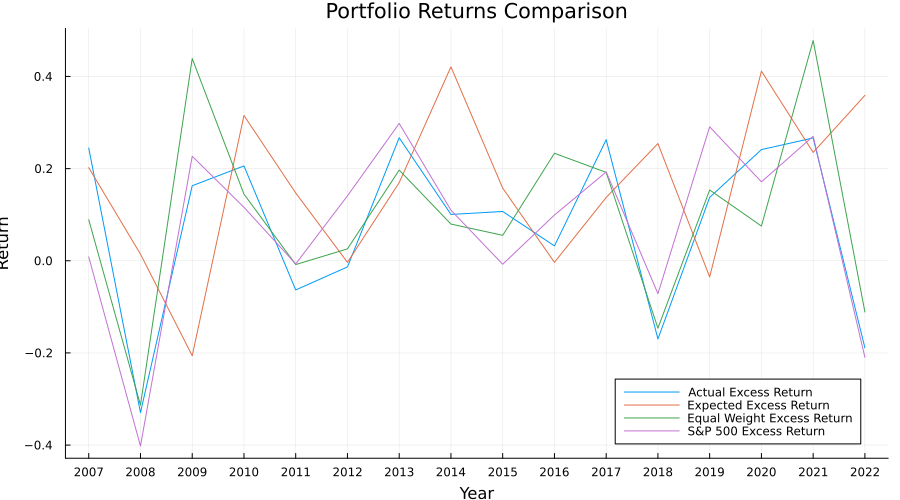

In [253]:
#plotting
xticks = year_start:1:year_end  # Every year tick
p = plot(returns.Year, [returns.Actual_excess_return, returns.Expected_excess_return, returns.Equal_weight_excess_return, returns.SP500_excess_return], label=["Actual Excess Return" "Expected Excess Return" "Equal Weight Excess Return" "S&P 500 Excess Return"], xlabel="Year", ylabel="Return", title="Portfolio Returns Comparison", xticks=xticks, size=(900, 500))

p

In [31]:
#returns regression analysis
data = CSV.read("Portfolio_Returns_Regression_Data.csv", DataFrame)
# Regress stock returns on the three factors

Row,Month,Portfolio_return,Mkt_excess_return,SMB,HML,RF
,String15,Float64,Float64,Float64,Float64,Float64
1,1/31/2007,1.25,1.4,0.13,-0.68,0.44
2,2/28/2007,1.17,-1.96,1.19,-0.14,0.38
3,3/30/2007,1.38,0.68,0.16,-0.97,0.43
4,4/30/2007,10.51,3.49,-2.16,-1.45,0.44
5,5/31/2007,6.06,3.24,0.24,-0.65,0.41
6,6/29/2007,1.29,-1.96,0.74,-1.05,0.4
7,7/31/2007,-1.28,-3.73,-2.61,-3.71,0.4
8,8/31/2007,1.47,0.92,-0.12,-1.86,0.42
9,9/28/2007,6.02,3.22,-2.23,-2.21,0.32


In [33]:
model = lm(@formula(Portfolio_return ~ Mkt_excess_return + SMB + HML), data)

# Print the summary of the regression
println(coeftable(model))

──────────────────────────────────────────────────────────────────────────────────
                        Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────
(Intercept)         0.463211    0.191939    2.41    0.0168   0.0845806   0.841842
Mkt_excess_return   1.00548     0.0427256  23.53    <1e-57   0.921202    1.08977
SMB                -0.175078    0.0827229  -2.12    0.0356  -0.338262   -0.0118936
HML                 0.0507087   0.0579775   0.87    0.3829  -0.0636614   0.165079
──────────────────────────────────────────────────────────────────────────────────


In [29]:
println(stock_data)

LoadError: UndefVarError: stock_data not defined

In [21]:
CSV.write("cov_table.csv", cov_matrix_df)
cov_matrix_df

LoadError: UndefVarError: cov_matrix_df not defined

In [4]:
(r,c)=size(portfolio)
tickers=portfolio[!,1]
industry=portfolio[!,2]
industries=["TECHNOLOGY", "CONSUMER STAPLES", "INDUSTRIALS", "CONSUMER DISCRETIONARY", "HEALTHCARE", "ENERGY", "FINANCIAL", "COMMUNICATION SERVICES", "REAL ESTATE", "MATERIALS", "UTILITIES"]
#expected_return=portfolio[!,6]
label=zeros(r,11) #11 industries
for a in 1:r
    for b in 1:11
        if portfolio[a,2]==industries[b]
            label[a,b]=1
        else
        end
    end
end

label

35×11 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                        ⋮
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [5]:
portfolio

Row,Stock,Industry,Beta,rf,E[rm],E[ri]
,String7,String31,Float64,Float64,Float64,Float64
1,AAPL,TECHNOLOGY,1.29,0.04,0.09,0.11
2,AMZN,TECHNOLOGY,1.26,0.04,0.09,0.1
3,BA,INDUSTRIALS,1.43,0.04,0.09,0.11
4,BAC,FINANCIAL,1.36,0.04,0.09,0.11
5,BPY,CONSUMER DISCRETIONARY,1.01,0.04,0.09,0.09
6,CAT,INDUSTRIALS,1.09,0.04,0.09,0.09
7,CL,CONSUMER STAPLES,0.49,0.04,0.09,0.06
8,COP,ENERGY,1.29,0.04,0.09,0.11
9,D,UTILITIES,0.44,0.04,0.09,0.06
